In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語描画
import holidays
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import os
from pathlib import Path
import statsmodels.api as sm
import re
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# ========== 1) 入力ファイル ==========
Daily_Shoppers = r"C:\Users\sk062\Downloads\提供用_店舗日別客数.txt"
Bookstore_Code = r"C:\Users\sk062\Downloads\提供用_書店コード.txt"
Daily_sales_details = r"C:\Users\sk062\Downloads\提供用_日別販売明細.txt"

# 出力先
output_dir = r"C:\Users\sk062\Downloads"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [3]:
# ========== 2) 読み込み ==========
Daily_Shoppers_df = pl.read_csv(Daily_Shoppers, separator='\t')
Bookstore_Code_df = pl.read_csv(Bookstore_Code, separator='\t')
Daily_sales_details_df = pl.read_csv(Daily_sales_details, separator='\t')

In [4]:
comic_research = pl.read_csv(r"C:\Users\sk062\Downloads\comic_research_saved.csv" ,encoding="shift-jis")
nobel_research = pl.read_csv(r"C:\Users\sk062\Downloads\nobel_research_saved.csv" ,encoding="shift-jis")

In [5]:
Daily_Shoppers_df_copy = Daily_Shoppers_df.clone()
Bookstore_Code_df_copy = Bookstore_Code_df.clone() 
Daily_sales_details_df_copy = Daily_sales_details_df.clone() 

In [6]:
# カテゴリ列を付与
Daily_sales_details_df_copy = Daily_sales_details_df_copy.with_columns([
    pl.when(pl.col("大分類").str.contains("文庫"))
      .then(pl.lit("小説"))
      .when(pl.col("大分類").str.contains("コミック"))
      .then(pl.lit("漫画"))
      .otherwise(pl.lit("その他"))
      .alias("カテゴリ")
])

In [7]:
Daily_sales_details_df_copy = Daily_sales_details_df_copy.with_columns([
    pl.col("大分類").str.contains("文庫").fill_null(False).cast(pl.Int8).alias("is_novel"),
    pl.col("大分類").str.contains("コミック").fill_null(False).cast(pl.Int8).alias("is_comic"),
])

novel_sales = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_novel") == 1)
    .select(pl.col("POS販売冊数").cast(pl.Int64).sum().alias("合計"))
)["合計"][0] or 0

comic_sales = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_comic") == 1)
    .select(pl.col("POS販売冊数").cast(pl.Int64).sum().alias("合計"))
)["合計"][0] or 0

In [8]:
# --- 売上金額計算 ---
Daily_sales_details_df_copy = Daily_sales_details_df_copy.with_columns([
    (pl.col("本体価格") * pl.col("POS販売冊数")).alias("売上金額")
])

In [9]:
# ▼ 小説・漫画の年間売上金額を計算
novel_sales_amt = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_novel") == 1)
    ["売上金額"]
    .sum()
)

comic_sales_amt = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_comic") == 1)
    ["売上金額"]
    .sum()
)

In [10]:
# ▼ 文字列の日付を Datetime 型に変換
Daily_sales_details_df_copy = Daily_sales_details_df_copy.with_columns([
    pl.col("日付").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f", strict=False).alias("日付_dt")
])

In [11]:
# ▼ 年・月・日を抽出して列追加
Daily_sales_details_df_copy = Daily_sales_details_df_copy.with_columns([
    pl.col("日付_dt").dt.year().alias("年"),
    pl.col("日付_dt").dt.month().alias("月"),
    pl.col("日付_dt").dt.day().alias("日")
])

In [12]:
# ▼ 小説・漫画ごとの日別売上を集計
Day_sales = (
    Daily_sales_details_df_copy
    .group_by(["年", "月", "日"])
    .agg([
         (pl.col("売上金額") * pl.col("is_novel")).sum().alias("小説_売上金額"),
         (pl.col("売上金額") * pl.col("is_comic")).sum().alias("漫画_売上金額"),
         (pl.col("POS販売冊数") * pl.col("is_novel")).sum().alias("小説_販売冊数"),
         (pl.col("POS販売冊数") * pl.col("is_novel")).sum().alias("画_販売冊数")
    ])
    .sort(["年", "月", "日"])
)

In [13]:
comic_research = comic_research.with_columns(
    pl.col('日').str.to_datetime("%Y/%m/%d")  # 日付の形式に合わせてフォーマットを指定
)
nobel_research = nobel_research.with_columns(
    pl.col('年月日').str.to_datetime("%Y/%m/%d")  # 日付の形式に合わせてフォーマットを指定
)

In [14]:
# フラグ側に結合キー(年, 月, 日)を作成
comic_research = comic_research.with_columns([
    pl.col("日").dt.year().alias("年"),
    pl.col("日").dt.month().alias("月"),
    pl.col("日").dt.day().alias("日"),
])

# フラグ側に結合キー(年, 月, 日)を作成
nobel_research = nobel_research.with_columns([
    pl.col('年月日').dt.year().alias("年"),
    pl.col('年月日').dt.month().alias("月"),
    pl.col('年月日').dt.day().alias("日"),
])

In [15]:
select_columns_nobel = [
 'レディース文庫: (日本)',
 '日本文庫: (日本)',
 '官能文庫: (日本)',
 '特殊文庫: (日本)',
 '学術・教養: (日本)',
 '海外文学: (日本)',
 '雑学文庫: (日本)',
 '年',
 '月',
 '日']

Day_sales = Day_sales.join(nobel_research.select(select_columns_nobel), on=["年", "月", "日"], how="left")

In [16]:
select_columns_comic = [
'日',
 'マニア',
 'レディース',
 '児童',
 '少女（中高生・一般）',
 '少女（小中学生）',
 '少年（中高生・一般）',
 '少年（小中学生）',
 '廉価版',
 '成人',
 '耽美',
 '青年（一般）',
 '青年（中高年）',
 'ｗｅｂ発',
 '年',
 '月'    
]

Day_sales = Day_sales.join(comic_research.select(select_columns_comic), on=["年", "月", "日"], how="left")

In [17]:
# ========== 新しい関数の定義 ==========
def calculate_top_x_share_flag(df, category_col, top_x, percent, new_col_name):
    """
    指定されたカテゴリ（小説 or 漫画）において、
    日ごとの販売数Top X冊の合計が、そのカテゴリの日の全体販売数の percent% を超えているかを判定する。
    1: 超えている, 0: 超えていない
    """
    
    # 1. 対象カテゴリに絞り込み、日別・書名別に集計
    target_df = df.filter(pl.col(category_col) == 1)
    daily_book_sales = target_df.group_by(["日付_dt", "書名"]).agg(
        pl.col("POS販売冊数").sum().alias("販売数")
    )
    
    # 2. 日別の「全体販売数」を算出
    daily_total = daily_book_sales.group_by("日付_dt").agg(
        pl.col("販売数").sum().alias("全体販売数")
    )
    
    # 3. 日別の「Top X冊の合計販売数」を算出
    # (日付ごとに販売数降順でソートし、上位X件を取得して合計)
    daily_top_x = (
        daily_book_sales
        .sort(["日付_dt", "販売数"], descending=[False, True])
        .group_by("日付_dt")
        .agg(pl.col("販売数").head(top_x).sum().alias("TopX合計販売数"))
    )
    
    # 4. 全体とTop Xを結合し、割合を計算してフラグ(0/1)化
    result_df = (
        daily_total
        .join(daily_top_x, on="日付_dt", how="left")
        .with_columns([
            # 割合判定: TopX合計 / 全体 > percent * 0.01
            ((pl.col("TopX合計販売数") / pl.col("全体販売数")) > (percent * 0.01))
            .cast(pl.Int8) # Booleanを0,1に変換
            .fill_null(0)  # 売上がない日は0
            .alias(new_col_name)
        ])
        .select(["日付_dt", new_col_name]) # 必要な列だけ残す
    )
    
    return result_df

# ========== 関数の実行 ==========
# 例: 小説で、Top 10冊が売上の 10% より高いか (フラグ列名: novel_top5_over30)
novel_flag_df = calculate_top_x_share_flag(
    Daily_sales_details_df_copy, 
    category_col="is_novel", 
    top_x=10, 
    percent=10, 
    new_col_name="novel_top10_over10"
)

# 例: 漫画で、Top 10冊が売上の 10% より高いか (フラグ列名: comic_top10_over50)
comic_flag_df = calculate_top_x_share_flag(
    Daily_sales_details_df_copy, 
    category_col="is_comic", 
    top_x=10, 
    percent=10, 
    new_col_name="comic_top10_over10"
)

In [18]:
# フラグ側に結合キー(年, 月, 日)を作成
novel_flag_df = novel_flag_df.with_columns([
    pl.col("日付_dt").dt.year().alias("年"),
    pl.col("日付_dt").dt.month().alias("月"),
    pl.col("日付_dt").dt.day().alias("日"),
])

In [19]:
comic_flag_df = comic_flag_df.with_columns([
    pl.col("日付_dt").dt.year().alias("年"),
    pl.col("日付_dt").dt.month().alias("月"),
    pl.col("日付_dt").dt.day().alias("日"),
])

In [20]:
# Day_sales に結合 (Polarsでの結合)
Day_sales = Day_sales.join(novel_flag_df.select(["年", "月", "日", "novel_top10_over10"]), on=["年", "月", "日"], how="left")
Day_sales = Day_sales.join(comic_flag_df.select(["年", "月", "日", "comic_top10_over10"]), on=["年", "月", "日"], how="left")

In [21]:
# ▼ 数値をカンマ付き・指数なしで表示
pd.set_option("display.float_format", "{:,.0f}".format)
pd.set_option("display.max_rows", None)  # 行の省略を防ぐ

In [22]:
# ▼ pandasに変換
Day_sales_pd = Day_sales.to_pandas()

# Day_sales_pd

In [23]:
# ▼ 1. カンマ付き文字列を数値化
Day_sales_pd["小説_売上金額"] = Day_sales_pd["小説_売上金額"].replace({",": ""}, regex=True).astype(int)
Day_sales_pd["漫画_売上金額"] = Day_sales_pd["漫画_売上金額"].replace({",": ""}, regex=True).astype(int)

# ▼ 2. 3月かどうかをワンホット化（3月→1、その他→0）
Day_sales_pd["July"] = (Day_sales_pd["月"] == 1).astype(int)
Day_sales_pd["February"] = (Day_sales_pd["月"] == 2).astype(int)
Day_sales_pd["March"] = (Day_sales_pd["月"] == 3).astype(int)
Day_sales_pd["April"] = (Day_sales_pd["月"] == 4).astype(int)
Day_sales_pd["May"] = (Day_sales_pd["月"] == 5).astype(int)
Day_sales_pd["June"] = (Day_sales_pd["月"] == 6).astype(int)
Day_sales_pd["August"] = (Day_sales_pd["月"] == 8).astype(int)
Day_sales_pd["September"] = (Day_sales_pd["月"] == 9).astype(int)
Day_sales_pd["October"] = (Day_sales_pd["月"] == 10).astype(int)
Day_sales_pd["November"] = (Day_sales_pd["月"] == 11).astype(int)
Day_sales_pd["December"] = (Day_sales_pd["月"] == 12).astype(int)

In [24]:
y_nobel = Day_sales_pd["小説_販売冊数"]

In [25]:
X = Day_sales_pd[[
    'レディース文庫: (日本)',
    '日本文庫: (日本)',
    '官能文庫: (日本)',
    '特殊文庫: (日本)',
    '学術・教養: (日本)',
    '海外文学: (日本)',
    '雑学文庫: (日本)',
    'マニア',
    'レディース',
    '児童',
    '少女（中高生・一般）',
    '少女（小中学生）',
    '少年（中高生・一般）',
    '少年（小中学生）',
    '廉価版',
    #'成人',
    '耽美',
    '青年（一般）',
    '青年（中高年）',
    'ｗｅｂ発',
    'novel_top10_over10',
    'comic_top10_over10',
    'July',
    'February',
    'March',
    'April',
    'May',
    'June',
    'August',
    'September',
    'October',
    'November',
    'December'
]]

In [26]:
# --- 【修正】ここでカラム名の記号（: や括弧）を削除します ---
# コロン、括弧、スペースを削除する処理
X = X.rename(columns=lambda x: re.sub(r'[:\(\)\s]', '', x))

In [27]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y_nobel, test_size=0.2, random_state=42)

In [28]:
# --- モデル定義（回帰用）lightgbm ---
reg_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    objective='regression',
    metric='rmse',
    
    # --- 【ここを追加・変更】 ---
    # 1. 葉に含まれる最小データ数（重要）
    # デフォルトは20ですが、全データ292件に対し20は大きすぎます。
    # ここを小さくしないと木が成長しません。
    min_child_samples=4, 
    
    # 2. 木の深さの制限
    # データが少ないため、深すぎると過学習し、浅すぎると学習しません。
    # 3〜5程度に制限して安定させます。
    max_depth=4,

    # 3. 過学習抑制（正則化）
    # min_child_samplesを下げると過学習しやすくなるため、少しブレーキをかけます。
    reg_alpha=0.1,  # L1正則化
    reg_lambda=0.1, # L2正則化
    
    # 4. 特徴量のサブサンプリング
    # 15個の特徴量のうち、毎回全てを使わず8割程度を使うことで汎化性能を上げます。
    colsample_bytree=0.7
)

In [29]:
# --- 学習 ---
reg_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(50)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 292, number of used features: 16
[LightGBM] [Info] Start training from score 1717.712329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
              metric='rmse', min_child_samples=4, n_estimators=1000,
              objective='regression', random_state=42, reg_alpha=0.1,
              reg_lambda=0.1)

In [30]:
# --- 予測・評価 ---
y_pred_reg = reg_model.predict(X_test)

print("\n=== 回帰モデル評価 ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_reg)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_reg):.4f}")


=== 回帰モデル評価 ===
RMSE: 218.8715
R2 Score: 0.0108


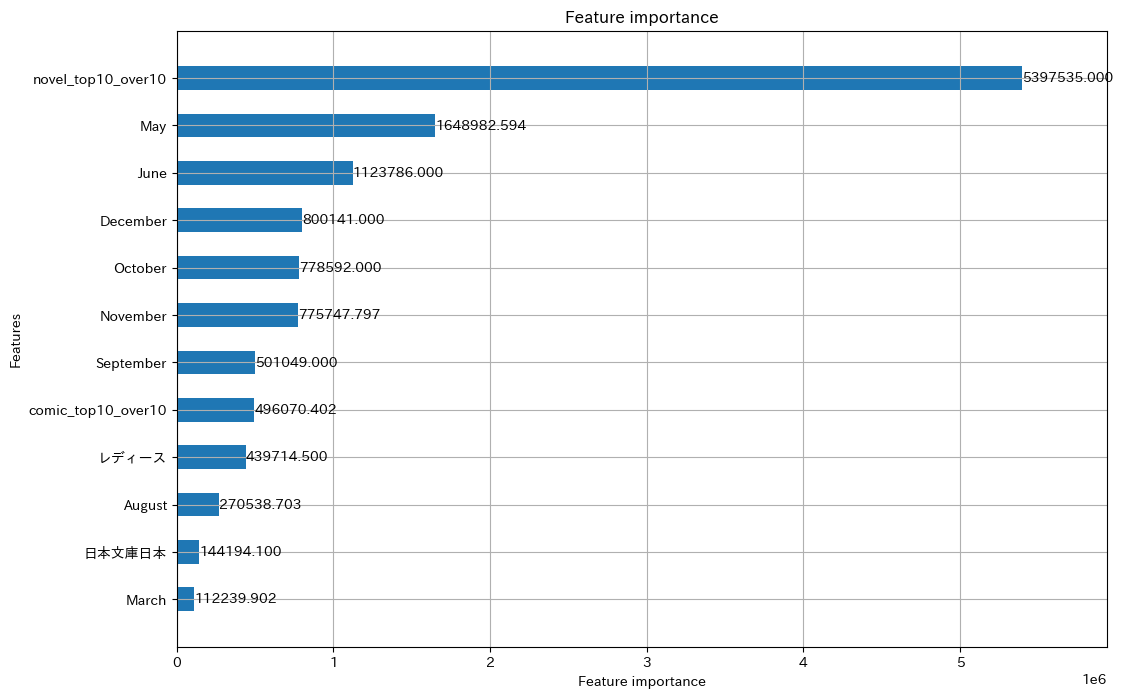

In [31]:
# 日本語表示のためにフォントサイズやサイズを調整
plt.rcParams["figure.figsize"] = (12, 8)

# feature_importanceのプロット
# importance_type='split' (デフォルト: 分岐回数) または 'gain' (情報利得) を指定可能
lgb.plot_importance(reg_model, importance_type='gain', max_num_features=30, height=0.5)
plt.show()

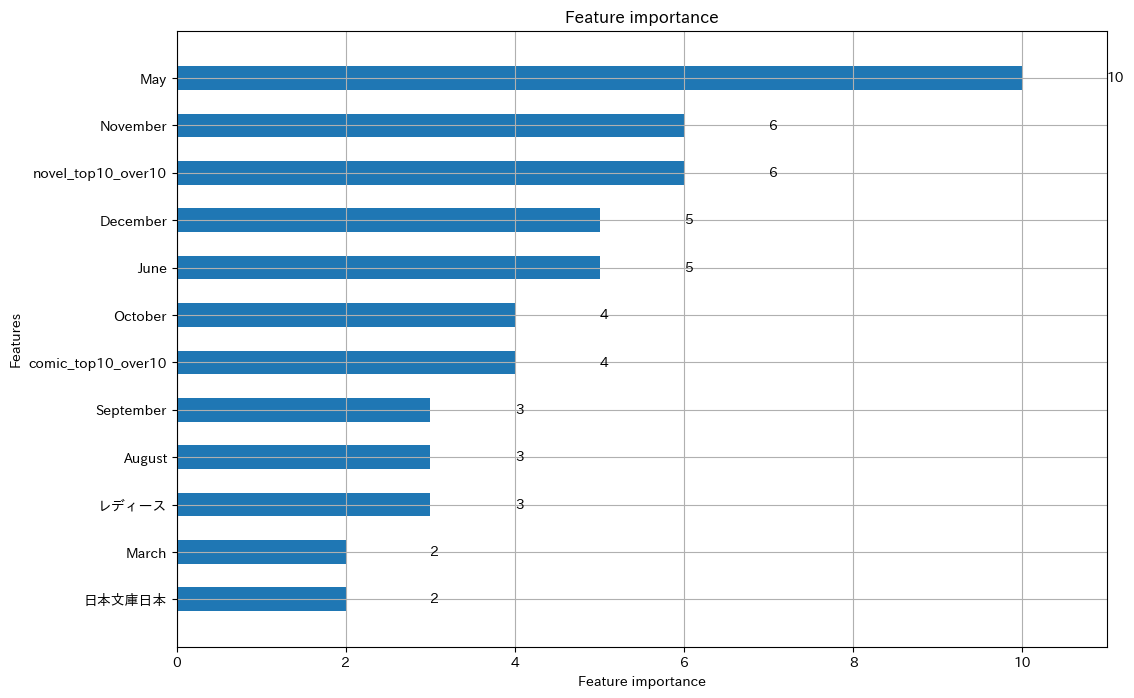

In [32]:
# 日本語表示のためにフォントサイズやサイズを調整
plt.rcParams["figure.figsize"] = (12, 8)

# feature_importanceのプロット
# importance_type='split' (デフォルト: 分岐回数) または 'gain' (情報利得) を指定可能
lgb.plot_importance(reg_model, importance_type='split', max_num_features=30, height=0.5)
plt.show()

In [33]:
# --- モデル定義（線形回帰） ---
# パラメータ設定はほぼ不要です
lr_model = LinearRegression()

# --- 学習 ---
lr_model.fit(X_train, y_train)

# --- 予測 ---
y_pred = lr_model.predict(X_test)

# --- 評価 ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== 線形回帰(Linear Regression) 評価 ===")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

=== 線形回帰(Linear Regression) 評価 ===
RMSE: 238.64345726630629
R2 Score: -0.17594599522005572


In [34]:
# random forest
# --- モデル定義（ランダムフォレスト） ---
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=500,    # 木の数（多いほうが安定します）
    
    # --- 【重要な調整ポイント】 ---
    max_depth=5,         # 木の深さ（データが少ないので浅めに制限）
    min_samples_leaf=4,  # 葉に含まれる最小データ数（LightGBMのmin_child_samplesと同じ役割）
    
    # 特徴量のサブサンプリング（過学習防止）
    max_features='sqrt', # 全特徴量のうち、ルートをとった数だけを各木で使用
    n_jobs=-1            # 全CPUを使って計算
)

# --- 学習 ---
# LightGBMと違い、eval_setは必須ではありません
rf_model.fit(X_train, y_train)

# --- 予測 ---
y_pred = rf_model.predict(X_test)

# --- 評価 ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [35]:
#print("=== ランダムフォレスト(Random Forest) 評価 ===")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 222.01562030769236
R2 Score: -0.017783428476447316


In [36]:
Day_sales_pd.shape

(366, 40)

In [37]:
Day_sales_pd.columns

Index(['年', '月', '日', '小説_売上金額', '漫画_売上金額', '小説_販売冊数', '画_販売冊数',
       'レディース文庫: (日本)', '日本文庫: (日本)', '官能文庫: (日本)', '特殊文庫: (日本)',
       '学術・教養: (日本)', '海外文学: (日本)', '雑学文庫: (日本)', 'マニア', 'レディース', '児童',
       '少女（中高生・一般）', '少女（小中学生）', '少年（中高生・一般）', '少年（小中学生）', '廉価版', '成人', '耽美',
       '青年（一般）', '青年（中高年）', 'ｗｅｂ発', 'novel_top10_over10', 'comic_top10_over10',
       'July', 'February', 'March', 'April', 'May', 'June', 'August',
       'September', 'October', 'November', 'December'],
      dtype='object')

In [38]:
# Cell 12 の修正案
Day_sales = (
    Daily_sales_details_df_copy
    .group_by(["年", "月", "日"])
    .agg([
         (pl.col("売上金額") * pl.col("is_novel")).sum().alias("小説_売上金額"),
         (pl.col("売上金額") * pl.col("is_comic")).sum().alias("漫画_売上金額"),
         (pl.col("POS販売冊数") * pl.col("is_novel")).sum().alias("小説_販売冊数"),
         (pl.col("POS販売冊数") * pl.col("is_comic")).sum().alias("漫画_販売冊数") # is_comicに変更
    ])
    .sort(["年", "月", "日"])
)

In [40]:
Day_sales.columns

['年', '月', '日', '小説_売上金額', '漫画_売上金額', '小説_販売冊数', '漫画_販売冊数']

In [41]:
# 小説の販売冊数合計
novel_sales = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_novel") == 1)
    .select(pl.col("POS販売冊数").cast(pl.Int64).sum().alias("合計"))
)["合計"][0] or 0

# 漫画の販売冊数合計
comic_sales = (
    Daily_sales_details_df_copy
    .filter(pl.col("is_comic") == 1)
    .select(pl.col("POS販売冊数").cast(pl.Int64).sum().alias("合計"))
)["合計"][0] or 0

In [42]:
novel_sales

630459

In [43]:
comic_sales

1383186

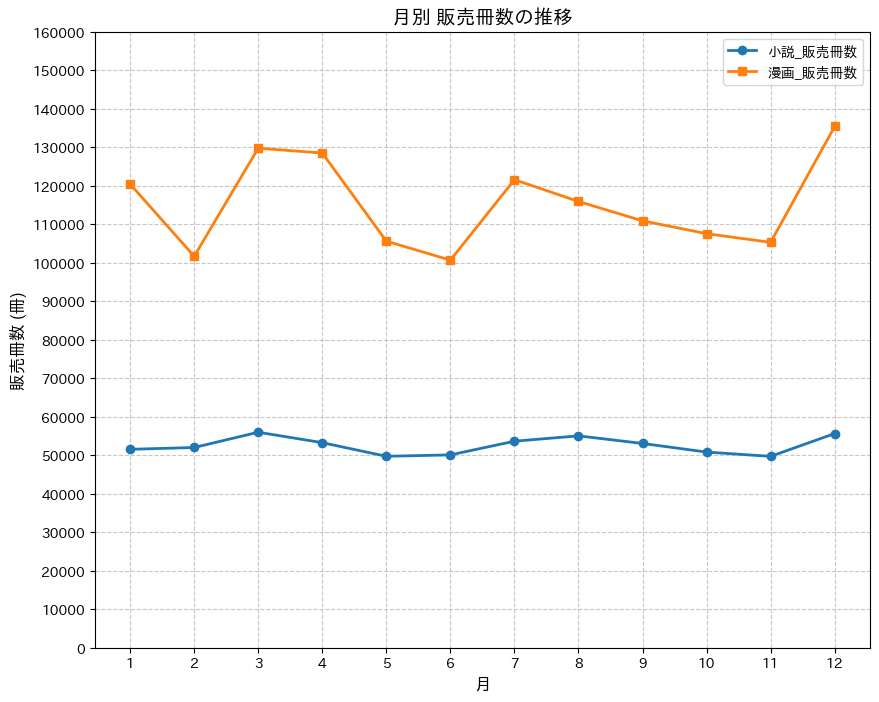

In [54]:
# 3. グラフの作成
plt.figure(figsize=(10, 8)) # 目盛りが増えるため、少し高さを出すと見やすくなります

# 小説の販売冊数をプロット
plt.plot(df_monthly['月'], df_monthly['小説_販売冊数'], 
         marker='o', label='小説_販売冊数', linewidth=2)

# 漫画の販売冊数をプロット
plt.plot(df_monthly['月'], df_monthly['漫画_販売冊数'], 
         marker='s', label='漫画_販売冊数', linewidth=2)

# --- y軸の設定 ---
# 最大値を160000に設定
plt.ylim(0, 160000)

# y軸を10000刻みに設定
# np.arange(開始, 終了, ステップ) を使用します
plt.yticks(np.arange(0, 160001, 10000))

# 4. グラフの装飾
plt.title('月別 販売冊数の推移', fontsize=14)
plt.xlabel('月', fontsize=12)
plt.ylabel('販売冊数 (冊)', fontsize=12)
plt.xticks(df_monthly['月'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 5. 表示
plt.show()

In [48]:
Day_sales.type()

AttributeError: 'DataFrame' object has no attribute 'type'